In [98]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ImageNormalize, AsinhStretch
from astropy.time import Time
from skimage import measure
import skimage.measure.profile
import matplotlib.lines as mlines
from matplotlib.patches import Polygon
from glob import glob
import cv2
import sunpy
import sunpy.map
from sunpy.time import parse_time
from scipy.io import readsav
import dkist

In [4]:
slit_coordinates_sav = readsav("../../../sav/dynamic_fibrils/slit_sudip/slit_locations.sav", verbose=True)

--------------------------------------------------
Date: Thu Nov 14 10:08:50 2024
User: mandal
Host: Mansu-SL22
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 7 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 4 are of type VARIABLE
--------------------------------------------------
Available variables:
 - slit1 [<class 'numpy.ndarray'>]
 - slit2 [<class 'numpy.ndarray'>]
 - slit3 [<class 'numpy.ndarray'>]
 - slit4 [<class 'numpy.ndarray'>]
--------------------------------------------------


In [6]:
slit_coordinates_sav["slit1"].shape

(78, 2)

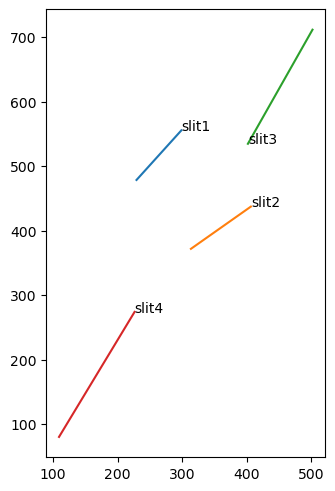

In [22]:
fig, ax = plt.subplots(layout='constrained')
for slit in ("slit1", "slit2", "slit3", "slit4"):
    ax.plot(slit_coordinates_sav[slit][:, 0], slit_coordinates_sav[slit][:, 1], label=slit)
    ax.text(slit_coordinates_sav[slit][0, 0], slit_coordinates_sav[slit][0, 1], slit)
ax.set_aspect('equal')

In [7]:
eui_map_files = sorted(glob("../../../src/EUI/HRI/euv174/20221024/coalign_to_vbi/*.fits"))

In [61]:
def get_stackplot_intensity(x_select, y_select, eui_map_files=eui_map_files):
    pixels_idy, pixels_idx = measure.profile._line_profile_coordinates((y_select[0], x_select[0]),
                            (y_select[1], x_select[1]), linewidth=15)

    pixels_idy_center = np.nanmean(pixels_idy,axis=1)
    pixels_idx_center = np.nanmean(pixels_idx,axis=1)

    pixel_distance = np.cumsum(np.sqrt(np.diff(pixels_idx_center)**2 + np.diff(pixels_idy_center)**2))
    pixel_distance = np.insert(pixel_distance,0,0)
    pixel_distance_interp = np.linspace(pixel_distance[0],pixel_distance[-1],len(pixel_distance))

    intensity = []

    for tt in range(len(eui_map_files)):
        eui_map = sunpy.map.Map(eui_map_files[tt])
        line = measure.profile_line(eui_map.data, 
                                    (y_select[0], x_select[0]), (y_select[1], x_select[1]),
                                    linewidth=15)
        
        intensity_interp = np.interp(pixel_distance_interp,pixel_distance,line)
        intensity.append(intensity_interp)

    slit_intensity = np.array(intensity).T
    # slit_intensity = slit_intensity - cv2.GaussianBlur(slit_intensity,(1,31),0,9)

    slit_intensity = slit_intensity/np.nanmean(slit_intensity, axis=1)[:, np.newaxis]
    slit_intensity = slit_intensity/np.nanmean(slit_intensity, axis=0)[np.newaxis, :]

    return slit_intensity, pixels_idx, pixels_idy

In [63]:
(slit_4_intensity, slit_4_pixels_idx,
slit_4_pixels_idy) = get_stackplot_intensity(slit_coordinates_sav["slit4"][np.r_[0,-1],0].astype(np.float64),
                                           slit_coordinates_sav["slit4"][np.r_[0,-1],1].astype(np.float64))

In [62]:
(slit_1_intensity, slit_1_pixels_idx,
slit_1_pixels_idy) = get_stackplot_intensity(slit_coordinates_sav["slit1"][np.r_[0,-1],0].astype(np.float64),
                                           slit_coordinates_sav["slit1"][np.r_[0,-1],1].astype(np.float64))

(slit_2_intensity, slit_2_pixels_idx,
slit_2_pixels_idy) = get_stackplot_intensity(slit_coordinates_sav["slit2"][np.r_[0,-1],0].astype(np.float64),
                                           slit_coordinates_sav["slit2"][np.r_[0,-1],1].astype(np.float64))

(slit_3_intensity, slit_3_pixels_idx,
slit_3_pixels_idy) = get_stackplot_intensity(slit_coordinates_sav["slit3"][np.r_[0,-1],0].astype(np.float64),
                                           slit_coordinates_sav["slit3"][np.r_[0,-1],1].astype(np.float64))

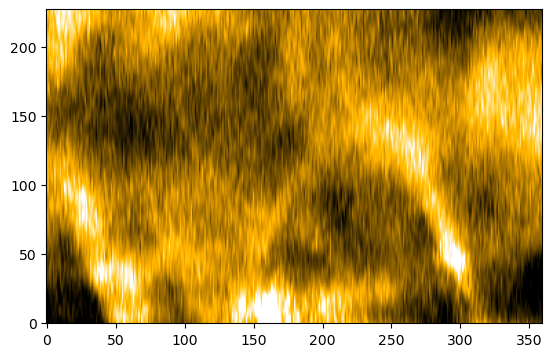

In [64]:
plt.imshow(slit_4_intensity, origin="lower", 
           norm=ImageNormalize(vmin=np.nanpercentile(slit_4_intensity, 1),
                               vmax=np.nanpercentile(slit_4_intensity, 99)),
                               cmap="sdoaia171")

In [39]:
eui_map_example = sunpy.map.Map("../../../src/EUI/HRI/euv174/20221024/coalign_wow_to_vbi/eui_map_seq_coalign_wow_to_vbi_181.fits")

In [71]:
def plot_slit_position(pixels_idx, pixels_idy, ax1, triangle_length=20, triangle_anchor_index=40, triangle_ratio=0.6,
                       color='#58B2DC', lw=1, alpha=0.8, text=None, text_color=None, text_offset=10, text_fontsize=10):
    boundary_x = np.concatenate((pixels_idx[:, 0], pixels_idx[-1, 1:], pixels_idx[-1::-1, -1], pixels_idx[0, -1::-1]))
    boundary_y = np.concatenate((pixels_idy[:, 0], pixels_idy[-1, 1:], pixels_idy[-1::-1, -1], pixels_idy[0, -1::-1]))

    slit_boundary_collection = []
    boundary_x_line2d_ax1 = mlines.Line2D(boundary_x, boundary_y, color=color, lw=lw, alpha=alpha)
    boundary_x_line2d_ax2 = mlines.Line2D(boundary_x, boundary_y, color=color, lw=lw, alpha=alpha)
    slit_boundary_collection.append(ax1.add_line(boundary_x_line2d_ax1))

    triangle_anchor_point_0 = np.array([pixels_idx[triangle_anchor_index, 0], pixels_idy[triangle_anchor_index, 0]])
    triangle_anchor_point_1 = np.array([pixels_idx[triangle_anchor_index + triangle_length, 0], pixels_idy[triangle_anchor_index + triangle_length, 0]])
    triangle_bottom_vec = triangle_anchor_point_1 - triangle_anchor_point_0
    triangle_bottom_vec_rot_90 = np.array([triangle_bottom_vec[1], -triangle_bottom_vec[0]])*triangle_ratio
    triangle_anchor_point_2 = triangle_anchor_point_0 + triangle_bottom_vec_rot_90

    triangle_points = np.vstack((triangle_anchor_point_0, triangle_anchor_point_1, triangle_anchor_point_2,))
    
    for ax_ in (ax1,):
        triangle_patch = Polygon(triangle_points, closed=True, edgecolor=color, facecolor=color, alpha=alpha)
        ax_.add_patch(triangle_patch)

    if text is not None:
        if text_color is None:
            text_color = color
        slit_center_x = np.nanmean(pixels_idx)
        slit_center_y = np.nanmean(pixels_idy)
        triangle_bottom_vec_rot_90_norm = triangle_bottom_vec_rot_90/np.linalg.norm(triangle_bottom_vec_rot_90)

        for ax_ in (ax1,):
            ax_.text(slit_center_x + text_offset*triangle_bottom_vec_rot_90_norm[0], 
                     slit_center_y + text_offset*triangle_bottom_vec_rot_90_norm[1], text,
                    color=text_color, fontsize=text_fontsize, ha='center', va='center',
                    )


    return slit_boundary_collection

Text(0.03, 0.9, 'Slit 4')

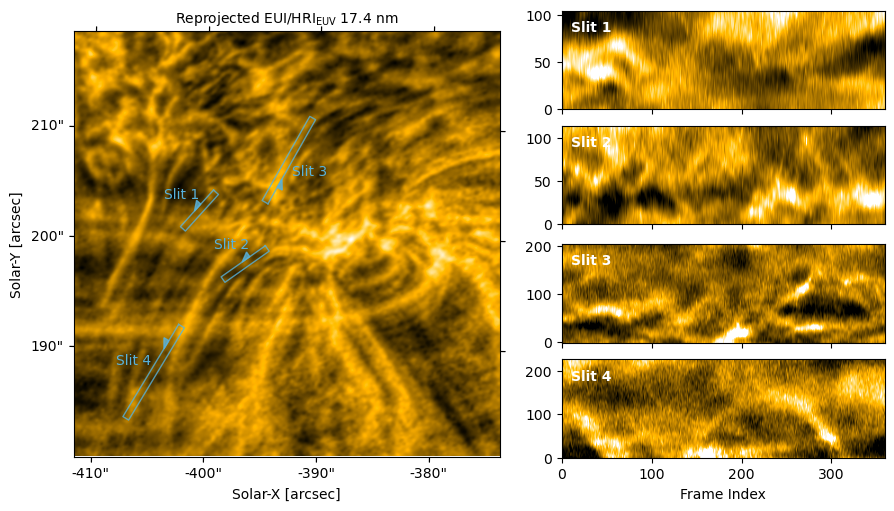

In [93]:
fig = plt.figure(figsize=(9,5), layout="constrained")
gs = fig.add_gridspec(1,2, width_ratios=[5,4])
gs1 = gs[1].subgridspec(4,1,)

ax1 = fig.add_subplot(gs[0], projection=eui_map_example)
ax1.imshow(eui_map_example.data, cmap="sdoaia171")


ax2 =  fig.add_subplot(gs1[0])
ax2.imshow(slit_1_intensity, origin="lower",cmap="sdoaia171",
        norm=ImageNormalize(vmin=np.nanpercentile(slit_1_intensity, 1),
                                   vmax=np.nanpercentile(slit_1_intensity, 99)),
         )
plot_slit_position(slit_1_pixels_idx, slit_1_pixels_idy, ax1, text="Slit 1", text_offset=50)

ax3 =  fig.add_subplot(gs1[1])
ax3.imshow(slit_2_intensity, origin="lower",cmap="sdoaia171",
        norm=ImageNormalize(vmin=np.nanpercentile(slit_2_intensity, 1),
                                          vmax=np.nanpercentile(slit_2_intensity, 99)),
          )
plot_slit_position(slit_2_pixels_idx, slit_2_pixels_idy, ax1, text="Slit 2", text_offset=50)

ax4 =  fig.add_subplot(gs1[2])
ax4.imshow(slit_3_intensity, origin="lower",cmap="sdoaia171",
        norm=ImageNormalize(vmin=np.nanpercentile(slit_3_intensity, 1),
                                          vmax=np.nanpercentile(slit_3_intensity, 99)),
        )
plot_slit_position(slit_3_pixels_idx, slit_3_pixels_idy, ax1, text="Slit 3", text_offset=50)

ax5 =  fig.add_subplot(gs1[3])
ax5.imshow(slit_4_intensity, origin="lower",cmap="sdoaia171",
        norm=ImageNormalize(vmin=np.nanpercentile(slit_4_intensity, 1),
                                                vmax=np.nanpercentile(slit_4_intensity, 99)),
                )
plot_slit_position(slit_4_pixels_idx, slit_4_pixels_idy, ax1, text="Slit 4", text_offset=50)

for ax_ in (ax2,ax3,ax4,ax5):
    ax_.set_aspect("auto")

for ax_ in (ax2,ax3,ax4):
    ax_.tick_params(axis="x", labelbottom=False)

ax1.coords[0].set_axislabel("Solar-X [arcsec]")
ax1.coords[1].set_axislabel("Solar-Y [arcsec]")

ax1.set_title(r"Reprojected EUI/HRI$_{\rm EUV}$ 17.4 nm", fontsize=10)
ax5.set_xlabel("Frame Index")

ax2.text(0.03, 0.9, "Slit 1", transform=ax2.transAxes, fontsize=10, color="white",
        weight="bold", va="top", ha="left")
ax3.text(0.03, 0.9, "Slit 2", transform=ax3.transAxes, fontsize=10, color="white",
        weight="bold", va="top", ha="left")
ax4.text(0.03, 0.9, "Slit 3", transform=ax4.transAxes, fontsize=10, color="white",
        weight="bold", va="top", ha="left")
ax5.text(0.03, 0.9, "Slit 4", transform=ax5.transAxes, fontsize=10, color="white",
        weight="bold", va="top", ha="left")




In [82]:
vbi_files = sorted(glob("../../../sav/DKIST_of/BJOLO/33_npy/*"))

In [112]:
def get_stackplot_intensity_vbi(x_select, y_select, vbi_files=vbi_files):
    pixels_idy, pixels_idx = measure.profile._line_profile_coordinates((y_select[0], x_select[0]),
                            (y_select[1], x_select[1]), linewidth=15)

    pixels_idy_center = np.nanmean(pixels_idy,axis=1)
    pixels_idx_center = np.nanmean(pixels_idx,axis=1)

    pixel_distance = np.cumsum(np.sqrt(np.diff(pixels_idx_center)**2 + np.diff(pixels_idy_center)**2))
    pixel_distance = np.insert(pixel_distance,0,0)
    pixel_distance_interp = np.linspace(pixel_distance[0],pixel_distance[-1],len(pixel_distance))

    intensity = []

    for tt in range(len(vbi_files)):
        line = measure.profile_line(np.load(vbi_files[tt])[32:-32,32:-32], 
                                (y_select[0], x_select[0]), (y_select[1], x_select[1]),
                                linewidth=5)
        
        intensity_interp = np.interp(pixel_distance_interp,pixel_distance,line)
        intensity.append(intensity_interp)

    slit_intensity = np.array(intensity).T
    # slit_intensity = slit_intensity - cv2.GaussianBlur(slit_intensity,(1,31),0,9)

    slit_intensity = slit_intensity/np.nanmean(slit_intensity, axis=1)[:, np.newaxis]
    slit_intensity = slit_intensity/np.nanmean(slit_intensity, axis=0)[np.newaxis, :]

    return slit_intensity, pixels_idx, pixels_idy

In [113]:
slit_1_intensity_vbi, _, _ = get_stackplot_intensity_vbi(slit_coordinates_sav["slit1"][np.r_[0,-1],0].astype(np.float64),
                                             slit_coordinates_sav["slit1"][np.r_[0,-1],1].astype(np.float64))

slit_2_intensity_vbi, _, _ = get_stackplot_intensity_vbi(slit_coordinates_sav["slit2"][np.r_[0,-1],0].astype(np.float64),
                                                slit_coordinates_sav["slit2"][np.r_[0,-1],1].astype(np.float64))

slit_3_intensity_vbi, _, _ = get_stackplot_intensity_vbi(slit_coordinates_sav["slit3"][np.r_[0,-1],0].astype(np.float64),
                                                slit_coordinates_sav["slit3"][np.r_[0,-1],1].astype(np.float64))

slit_4_intensity_vbi, _, _ = get_stackplot_intensity_vbi(slit_coordinates_sav["slit4"][np.r_[0,-1],0].astype(np.float64),
                                                slit_coordinates_sav["slit4"][np.r_[0,-1],1].astype(np.float64))

In [114]:
eui_date_beg = Time(sunpy.map.Map(eui_map_files[0]).meta['date_ear'])
eui_date_end = Time(sunpy.map.Map(eui_map_files[-1]).meta['date_ear'])

In [115]:
dkist_time = parse_time(dkist.load_dataset("../../../src/DKIST/vbi_1024/BJOLO/").headers["DATE-AVG"])

In [116]:
eui_beg_dkist_index = np.argmin(np.abs(dkist_time - eui_date_beg))
eui_end_dkist_index = np.argmin(np.abs(dkist_time - eui_date_end))

Text(0.03, 0.9, 'Slit 4')

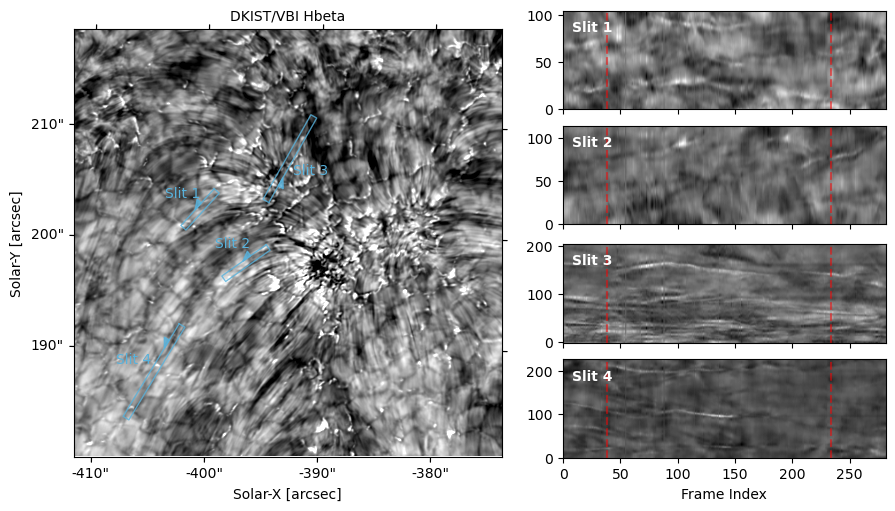

In [117]:
fig = plt.figure(figsize=(9,5), layout="constrained")
gs = fig.add_gridspec(1,2, width_ratios=[5,4])
gs1 = gs[1].subgridspec(4,1,)

ax1 = fig.add_subplot(gs[0], projection=eui_map_example)
ax1.imshow(np.load(vbi_files[125])[32:-32,32:-32], cmap="gray",
           norm=ImageNormalize(vmin=np.nanpercentile(np.load(vbi_files[125])[32:-32,32:-32], 1),
                               vmax=np.nanpercentile(np.load(vbi_files[125])[32:-32,32:-32], 99)))


ax2 =  fig.add_subplot(gs1[0])
ax2.imshow(slit_1_intensity_vbi, origin="lower",cmap="gray")
plot_slit_position(slit_1_pixels_idx, slit_1_pixels_idy, ax1, text="Slit 1", text_offset=50)

ax3 =  fig.add_subplot(gs1[1])
ax3.imshow(slit_2_intensity_vbi, origin="lower",cmap="gray")
plot_slit_position(slit_2_pixels_idx, slit_2_pixels_idy, ax1, text="Slit 2", text_offset=50)

ax4 =  fig.add_subplot(gs1[2])
ax4.imshow(slit_3_intensity_vbi, origin="lower",cmap="gray")
plot_slit_position(slit_3_pixels_idx, slit_3_pixels_idy, ax1, text="Slit 3", text_offset=50)

ax5 =  fig.add_subplot(gs1[3])
ax5.imshow(slit_4_intensity_vbi, origin="lower",cmap="gray")
plot_slit_position(slit_4_pixels_idx, slit_4_pixels_idy, ax1, text="Slit 4", text_offset=50)

for ax_ in (ax2,ax3,ax4,ax5):
    ax_.set_aspect("auto")
    ax_.axvline(eui_beg_dkist_index, color="red", linestyle="--", alpha=0.5)
    ax_.axvline(eui_end_dkist_index, color="red", linestyle="--", alpha=0.5)

for ax_ in (ax2,ax3,ax4):
    ax_.tick_params(axis="x", labelbottom=False)

ax1.coords[0].set_axislabel("Solar-X [arcsec]")
ax1.coords[1].set_axislabel("Solar-Y [arcsec]")

ax1.set_title(r"DKIST/VBI Hbeta", fontsize=10)
ax5.set_xlabel("Frame Index")

ax2.text(0.03, 0.9, "Slit 1", transform=ax2.transAxes, fontsize=10, color="white",
        weight="bold", va="top", ha="left")
ax3.text(0.03, 0.9, "Slit 2", transform=ax3.transAxes, fontsize=10, color="white",
        weight="bold", va="top", ha="left")
ax4.text(0.03, 0.9, "Slit 3", transform=ax4.transAxes, fontsize=10, color="white",
        weight="bold", va="top", ha="left")
ax5.text(0.03, 0.9, "Slit 4", transform=ax5.transAxes, fontsize=10, color="white",
        weight="bold", va="top", ha="left")
